In [7]:
import pandas as pd
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# from geopy.distance import vincenty
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# from mpl_toolkits.basemap import Basemap
import copy
import json
import math
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd

%matplotlib inline

import seaborn as sns

In [2]:
# url = 'https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Dockless_Vehicle_Trips.csv'
# data = pd.read_csv(url)

From https://chih-ling-hsu.github.io/2018/01/02/clustering-python

In [8]:
file_location = '../Dockless_data_Austin.csv'
df_loc = pd.read_csv(file_location, nrows=1000000)

In [9]:
geolink = 'data/Council Districts Fill.geojson'
geo = gpd.GeoDataFrame.from_file(geolink)

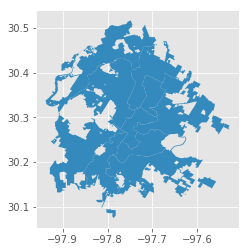

In [10]:
geo.plot();

In [12]:
df_loc.columns

Index(['id', 'device_id', 'vehicle_type', 'trip_duration', 'trip_distance',
       'start_time', 'end_time', 'modified_date', 'month', 'hour',
       'day_of_week', 'council_district_start', 'council_district_end',
       'origin_cell_id', 'destination_cell_id', 'year', 'start_latitude',
       'start_longitude', 'end_latitude', 'end_longitude'],
      dtype='object')

## Spatial Clustering

Using stations’ geo-information to do clustering

In [12]:
X = df_loc[['start_latitude', 'start_longitude']].values

### K-Means

In [13]:
%%time
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

#### Elbow Method

The Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset. This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn’t give much better modeling of the data.
Percentage of variance explained is the ratio of the between-group variance to the total variance.

In [74]:
%%time
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)

MemoryError: 

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


In [15]:
centers = kmeans.cluster_centers_


In [81]:
plt.scatter

<function matplotlib.pyplot.scatter>

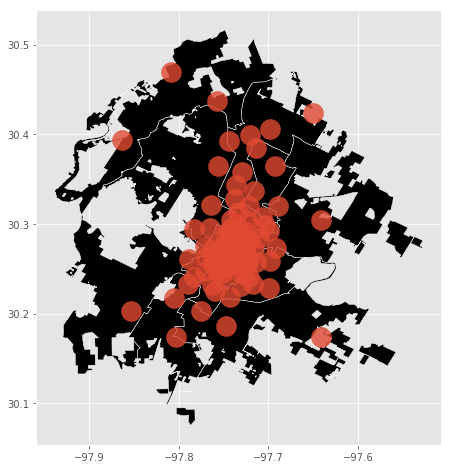

In [16]:
fig, ax = plt.subplots(1, figsize=(8,8))
geo.plot(ax=ax, color='black', edgecolor='white')
plt.scatter(centers[:, 1], centers[:, 0], s=400, alpha=0.8)

In [17]:
kmeans_200 = KMeans(n_clusters=200)
kmeans_200.fit(X)
y_kmeans = kmeans_200.predict(X)


In [18]:
centers_200 = kmeans_200.cluster_centers_


In [81]:
plt.scatter

<function matplotlib.pyplot.scatter>

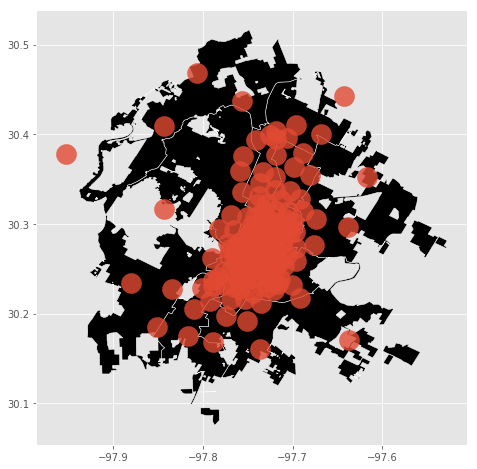

In [19]:
fig, ax = plt.subplots(1, figsize=(8,8))
geo.plot(ax=ax, color='black', edgecolor='white')
plt.scatter(centers_200[:, 1], centers_200[:, 0], s=400, alpha=0.8)

In [83]:
!ls

Council Districts Fill.geojson	Dockless_data_Austin.csv
Council Districts Fill.zip	dockless_scooters.ipynb


In [14]:
scooters = pd.read_csv(file_location)

In [15]:
scooters.columns

Index(['id', 'device_id', 'vehicle_type', 'trip_duration', 'trip_distance',
       'start_time', 'end_time', 'modified_date', 'month', 'hour',
       'day_of_week', 'council_district_start', 'council_district_end',
       'origin_cell_id', 'destination_cell_id', 'year', 'start_latitude',
       'start_longitude', 'end_latitude', 'end_longitude'],
      dtype='object')

In [54]:
# Let's see how many unique scooters are out there
scooters.device_id.nunique()

# this is higher than ~15k per City of Austin website
# let's investigate

26096

In [55]:
# let's calculate rights per every scooter
# possibly, some scooters have very few rides
# i doubt that however
ride_per_device = scooters[['device_id', 'id']].groupby('device_id').count()
ride_per_device.head()

,id
device_id,
00066528-4d85-4cc8-bacf-a904f3ec96d8,234
001302a8-573f-4305-98e2-2f719eb0d840,87
0016d2fd-6dec-4fd5-8834-e21cbcd98eac,172
00197264-a88c-4c8f-9f19-efe6c2c25dfb,25
0019f934-1dfb-4225-be32-1a6b647c6efc,90


In [56]:
ride_per_device.reset_index(inplace=True)

In [57]:
ride_per_device = ride_per_device.rename(columns={'id':'number_of_rides'})

In [58]:
ride_per_device.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26096 entries, 0 to 26095
Data columns (total 2 columns):
device_id          26096 non-null object
number_of_rides    26096 non-null int64
dtypes: int64(1), object(1)
memory usage: 407.8+ KB


In [31]:
for i in (5,10,20,50,100,200,500,1000,1000):
    print ('number of scooters with less than', i, 'rides', ride_per_device[ride_per_device['number_of_rides'] < i].count())

number of scooters with less than 5 rides number_of_rides    864
dtype: int64
number of scooters with less than 10 rides number_of_rides    1879
dtype: int64
number of scooters with less than 20 rides number_of_rides    3660
dtype: int64
number of scooters with less than 50 rides number_of_rides    8906
dtype: int64
number of scooters with less than 100 rides number_of_rides    15920
dtype: int64
number of scooters with less than 200 rides number_of_rides    22659
dtype: int64
number of scooters with less than 500 rides number_of_rides    26088
dtype: int64
number of scooters with less than 1000 rides number_of_rides    26096
dtype: int64
number of scooters with less than 1000 rides number_of_rides    26096
dtype: int64


In [38]:
# let's substract scooters with less than 50 rides from total scooters 
print(ride_per_device.count() - 8906)

number_of_rides    17190
dtype: int64


This is close to what the City states is the number

#### Let's do some charts

In [97]:
bins = [1, 10, 20, 50, 100, 200, 500, 1000, 5000, 10000]
labels = ['1-10','11-20','21-50','51-100', '101-200', '201-500', '501-1000', '1001-5,000','5001-10,000']
ride_per_device['ride_count_bin'] = pd.cut(ride_per_device['number_of_rides'], bins=bins, labels=labels)

In [90]:
y = ride_per_device.groupby(ride_per_device['ride_count_bin']).count()
y.reset_index(inplace=True)
y.head()

Text(0.5,0,'Categories')

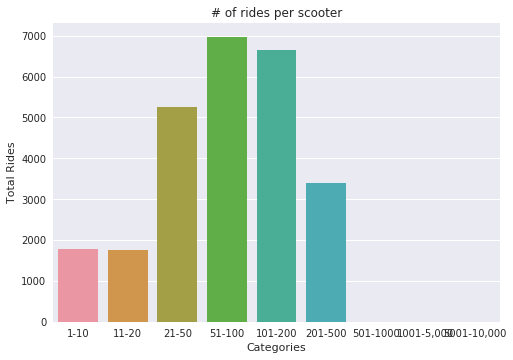

In [95]:
sns.barplot(y['ride_count_bin'],y['number_of_rides']) 
plt.title('# of rides per scooter')
plt.ylabel('Total Rides')
plt.xlabel('Categories')

## 2. Time Series

In [103]:
print(scooters['start_time'].head(200))

0      2018-06-29 17:30:00
1      2018-11-30 11:00:00
2      2018-10-02 15:15:00
3      2018-09-02 16:45:00
4      2018-09-28 11:45:00
5      2018-07-22 16:30:00
6      2018-10-28 09:30:00
7      2018-10-08 17:45:00
8      2018-06-16 22:00:00
9      2018-10-25 10:45:00
10     2018-07-13 18:00:00
11     2018-04-18 18:15:00
12     2018-12-04 02:45:00
13     2018-10-22 16:15:00
14     2018-04-20 12:30:00
15     2018-11-05 17:15:00
16     2018-11-29 11:15:00
17     2018-08-13 00:00:00
18     2018-11-17 15:30:00
19     2018-10-17 17:30:00
20     2018-07-02 16:00:00
21     2018-09-13 08:15:00
22     2018-11-24 13:15:00
23     2018-10-25 17:45:00
24     2018-06-24 16:00:00
25     2018-08-26 14:30:00
26     2018-10-10 12:15:00
27     2018-12-01 15:00:00
28     2018-09-24 16:45:00
29     2018-08-04 10:45:00
              ...         
170    2018-12-04 11:00:00
171    2018-09-24 06:30:00
172    2018-08-09 17:15:00
173    2018-11-04 18:45:00
174    2018-09-17 13:15:00
175    2018-10-08 15:00:00
1

In [99]:
scooters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612879 entries, 0 to 2612878
Data columns (total 20 columns):
id                        object
device_id                 object
vehicle_type              object
trip_duration             float64
trip_distance             float64
start_time                object
end_time                  object
modified_date             object
month                     float64
hour                      float64
day_of_week               float64
council_district_start    float64
council_district_end      float64
origin_cell_id            float64
destination_cell_id       float64
year                      float64
start_latitude            float64
start_longitude           float64
end_latitude              float64
end_longitude             float64
dtypes: float64(14), object(6)
memory usage: 398.7+ MB


In [105]:
scooters['start_time'] = pd.to_datetime(scooters['start_time'], format='%Y-%m-%d')

In [121]:
time_series_pd = scooters.set_index(scooters['start_time']).groupby(pd.Grouper(freq='D')).count()

In [122]:
time_series_pd.head()

,id,device_id,vehicle_type,trip_duration,trip_distance,start_time,end_time,modified_date,month,hour,day_of_week,council_district_start,council_district_end,origin_cell_id,destination_cell_id,year,start_latitude,start_longitude,end_latitude,end_longitude
start_time,,,,,,,,,,,,,,,,,,,,
2018-04-03,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2018-04-04,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2018-04-05,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112
2018-04-06,351,351,351,351,351,351,351,351,351,351,351,351,351,351,351,351,351,351,351,351
2018-04-07,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222,222


In [132]:
time_series_pd = time_series_pd[['id']].reset_index()

In [135]:
time_series_pd.head()
time_series_pd = time_series_pd.rename(columns={'id':'daily_n_trips'})

Text(0.5,1,'Frequency of Daily Number of Daily Rides')

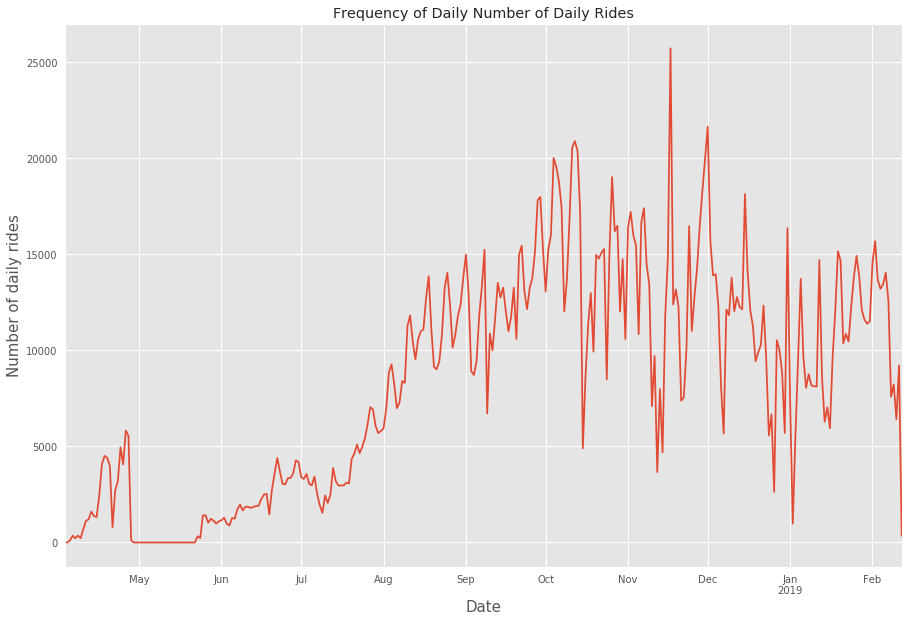

In [148]:
time_series_pd.plot.line(x='start_time', y='daily_n_trips', figsize=(15,10), legend=False)
plt.ylabel('Number of daily rides', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.title('Frequency of Daily Number of Daily Rides')

(17744, 17956)

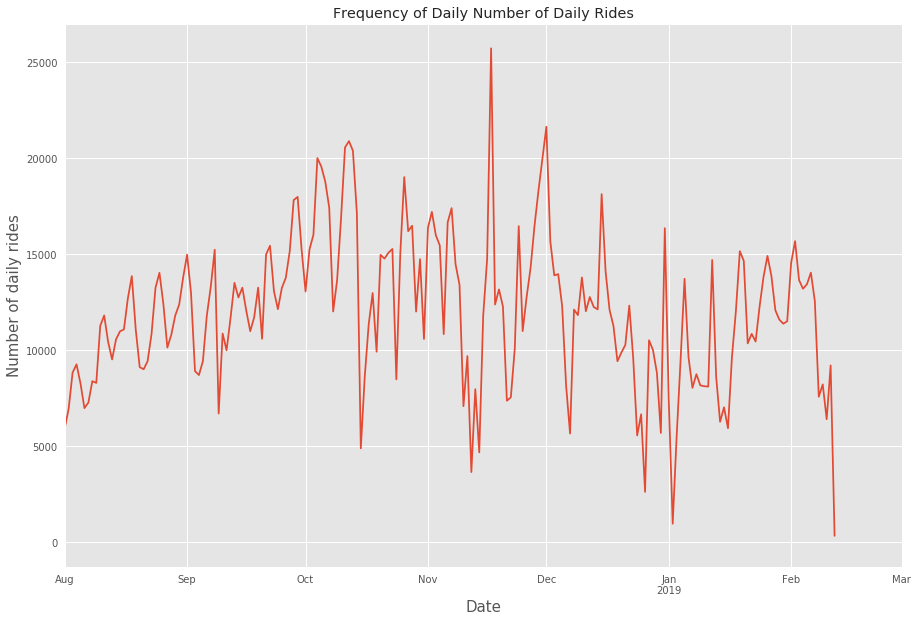

In [149]:
time_series_pd.plot.line(x='start_time', y='daily_n_trips', figsize=(15,10), legend=False)
plt.ylabel('Number of daily rides', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.title('Frequency of Daily Number of Daily Rides')
plt.xlim('2018-08','2019-03')

(17836, 17866)

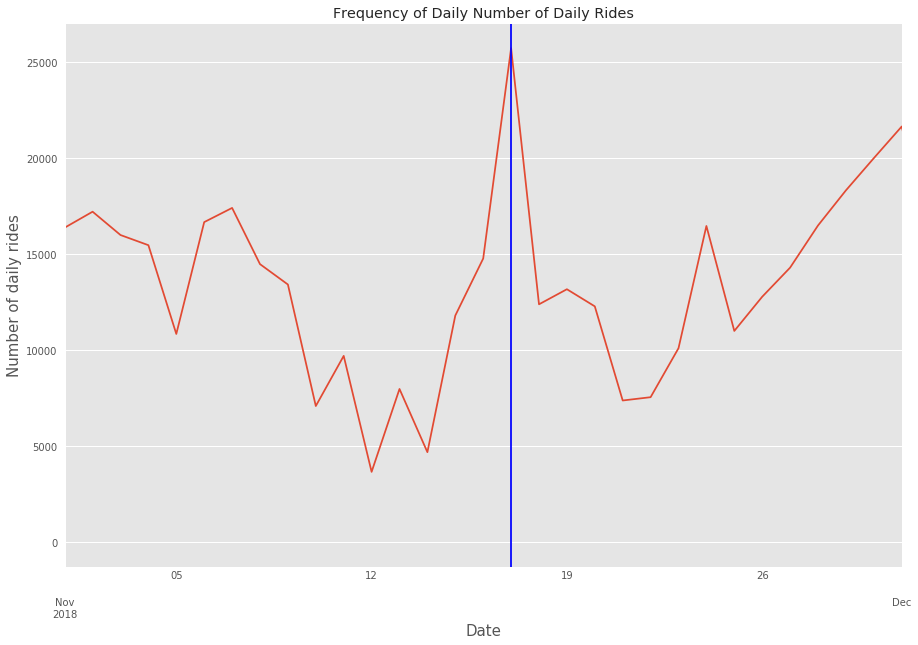

In [164]:
time_series_pd.plot.line(x='start_time', y='daily_n_trips', figsize=(15,10), legend=False)
plt.ylabel('Number of daily rides', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.title('Frequency of Daily Number of Daily Rides')
plt.axvline('2018-11-17',c='b')
plt.xticks()
plt.xlim('2018-11','2018-12')

https://www.13wmaz.com/video/weather/forecast/7-day/austin-saturday-night-forecast-11-17-18/93-8336786

https://www.austintexas.org/austin-insider-blog/post/november-top-events-festivals/